In [1]:
%matplotlib inline

from scipy.misc import *

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from scipy.special import logit
from theano import shared
from itertools import product

import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Load the survey data
index1 = pd.read_excel('/Users/deborahchung/Dropbox/PW_Columbia/RawData/IN10001.xls')
# index4 = preprocess(pd.read_excel('data/RawData/IN10004.xls'))
# index5 = preprocess(pd.read_excel('data/RawData/IN10005.xls'))
index6 = pd.read_excel('/Users/deborahchung/Dropbox/PW_Columbia/RawData/IN10006.xls')
# index7 = preprocess(pd.read_excel('data/RawData/IN10007.xls'))

common_columns = list(set(index1.columns).intersection(set(index6.columns)))


file_nums = [1,4,5,6,7]

df = pd.DataFrame()

for num in file_nums:
    df_temp = pd.read_excel('/Users/deborahchung/Dropbox/PW_Columbia/RawData/IN1000{}.xls'.format(num))
    df_temp['source'] = 'IN1000{}'.format(num)
#     print(df_temp.head())
#     df.append(df_temp)
    df = pd.concat([df, df_temp])
    common_data = df[common_columns]

# Create a new dataframe that only contains the demographic information that's included in each survey

# Note: Changed this to index6 from index7
# common_columns = list(set(index1.columns).intersection(set(index6.columns)))
# common_data = pd.concat([index1[common_columns],
#                          index4[common_columns],
#                          index5[common_columns],
#                          index6[common_columns],
#                          index7[common_columns]])

# Drop the columns that don't contain demographic information
common_data.drop(['ID', 'ADID IDFA', 'Time Started', 'Time Finished'], axis=1, inplace=True)

# Drop the columns where area is missing since the distributions for each demographic doesn't differ much
#index1 = index1.loc[index1['Area'] != 'Unknown', :]
index6 = index6[index6.Area != 'Unknown']
common_data = common_data.loc[common_data['Area'] != 'Unknown', :]

/Users/deborahchung/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
index6.head()

,ID,Time Started,Time Finished,OS,Country,Area,City,Provider,Gender,Age,...,Gamer,Value Shopper,Food and Dining Lover,Entertainment Enthusiast,Fashionista,Job Seeker,Insurance,Real Estate,Car Purchase,ADID IDFA
0,1093256017,2018-01-27 16:24:41,2018-01-27 16:28:42,Android,US,Illinois,Centralia,Verizon Wireless,male,25 - 34,...,True,True,True,True,True,NaN,NaN,NaN,NaN,79041a10-1815-4c98-b993-53ed9e63adbc
1,42384573,2018-01-27 16:26:03,2018-01-27 16:28:22,Android,US,California,Rialto,MetroPCS,male,45 - 54,...,False,False,False,False,False,NaN,NaN,NaN,NaN,ca91af1e-5c2e-4501-9319-97f9e3b16cb6
2,999822156,2018-01-27 16:26:51,2018-01-27 16:28:17,Android,US,Pennsylvania,Pittsburgh,NaN,male,18 - 24,...,True,False,False,True,False,NaN,NaN,NaN,NaN,NaN
3,-1522889414,2018-01-27 16:27:04,2018-01-27 16:28:13,Android,US,Georgia,Atlanta,T-Mobile,male,18 - 24,...,True,True,True,True,False,NaN,NaN,NaN,NaN,a5b35608-4e65-4ec4-9551-8aa06033e56f
4,-299564538,2018-01-27 16:23:44,2018-01-27 16:28:05,Android,US,Pennsylvania,Unknown,Verizon Wireless,male,45 - 54,...,True,True,True,True,True,NaN,NaN,NaN,NaN,ea51c835-62c0-4078-b3bc-f1ddd01bf003


In [9]:
# Encode demographic columns and create marginal demographic columns using an overall dataset
def encode_demo(index, common):
    age_gender_enc = LabelEncoder()
    
    # Enumerate the possible values for each variable using the overall dataset
#     gender_list = common['Gender'].unique()
#     age_list = common['Age'].unique()
    # Generate all possible combinations for each pair of variables using the overall dataset
    age_gender_list = [str(marginal) for marginal in product(common['Age'].unique(), common['Gender'].unique())]
    # Fit each LabelEncoder instance to its respective list of values
#     gender_enc.fit(gender_list)
    #race_enc.fit(race_list)
#     age_enc.fit(age_list)
    age_gender_enc.fit(age_gender_list)
    # Encode the individual categories as integers
#     index['Gender Encoded'] = gender_enc.transform(index['Gender'])
    #index['Race Encoded'] = race_enc.transform(index['Race'])
#     index['Age Encoded'] = age_enc.transform(index['Age'])
    #index['Area Encoded'] = area_enc.transform(index['Area'])
    #index['Education Encoded'] = edu_enc.transform(index['Education'])
    #index['Division Encoded'] = div_enc.transform(index['US Census Division'])
    
    # Create new columns for the marginal categories 
    def concat(col1, col2):
        pair = (col1, col2)
        return str(pair)

    #index['Race_Gender'] = index[['Race', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    #index['Age_Education'] = index[['Age', 'Education']].apply(lambda row: concat(row[0], row[1]), axis=1)
    index['Age_Gender'] = index[['Age', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
    # Encode the marginal categories as integers
    #index['Race_Gender'] = race_gender_enc.transform(index['Race_Gender'])
    #index['Age_Education'] = age_edu_enc.transform(index['Age_Education'])
    index['Age_Gender'] = age_gender_enc.transform(index['Age_Gender'])
    return index

# Perform one hot encoding on the possible answers for any given question
def ohe_question(index, question):
#     col_name = ' '.join(question.split(' ')[:4])
#     index = pd.concat([index,
#                        pd.get_dummies(index[question],
#                                       prefix=col_name,
#                                       prefix_sep='|')],
#                       axis=1)
    question_col = index[question]
    dummy_cols = pd.get_dummies(question_col, prefix='More Important Quality', prefix_sep='|')
    index.drop(question, axis=1, inplace=True)
    new_df = pd.concat([index, dummy_cols], axis=1)
    return new_df

In [10]:
index6 = encode_demo(index6, common_data)
common_data_encoded = encode_demo(common_data, common_data)
common_data_encoded.head() 

,Employment Status,Real Estate,Job Seeker,Area,US Census Region,Entertainment Enthusiast,US Congressional District,Food and Dining Lover,Number of children,Year Of Birth,...,DMA Name,Traveler,Career,Who will you vote for in the House of Representatives in 2018?,Country,Productivity Booster,Race,Car Purchase,Marital Status,Age_Gender
0,employed_for_wages,NaN,NaN,Minnesota,Midwest,True,NaN,True,zero,1984,...,Minneapolis-St. Paul,True,health_care_and_social_assistance,Will vote other/not sure,US,False,white,NaN,married,4
2,homemaker,NaN,NaN,Texas,South,NaN,14.0,NaN,three,1962,...,Beaumont-Port Arthur,NaN,other,Will vote Republican,US,NaN,asian,NaN,married,10
3,homemaker,NaN,NaN,New York,Northeast,True,22.0,True,two,1996,...,Utica,False,homemaker,Will vote Democratic,US,False,multiracial,NaN,single,2
4,employed_for_wages,NaN,NaN,District of Columbia,South,NaN,NaN,NaN,one,1979,...,"Washington, Dc (Hagrstwn)",NaN,construction,Will vote Republican,US,NaN,white,NaN,single,6
5,employed_for_wages,NaN,NaN,Texas,South,True,NaN,True,five,1976,...,NaN,False,hotel_and_food_services,Will vote other/not sure,US,False,white,NaN,married,7


In [11]:
question = 'Which quality is more important for children: obedience vs. self-reliance?'
index6 = ohe_question(index6, question)

In [12]:
index6.head() 

,ID,Time Started,Time Finished,OS,Country,Area,City,Provider,Gender,Age,...,Fashionista,Job Seeker,Insurance,Real Estate,Car Purchase,ADID IDFA,Age_Gender,More Important Quality|Don't know,More Important Quality|Obedience,More Important Quality|Self-reliance
0,1093256017,2018-01-27 16:24:41,2018-01-27 16:28:42,Android,US,Illinois,Centralia,Verizon Wireless,male,25 - 34,...,True,NaN,NaN,NaN,NaN,79041a10-1815-4c98-b993-53ed9e63adbc,5,0,0,1
1,42384573,2018-01-27 16:26:03,2018-01-27 16:28:22,Android,US,California,Rialto,MetroPCS,male,45 - 54,...,False,NaN,NaN,NaN,NaN,ca91af1e-5c2e-4501-9319-97f9e3b16cb6,9,0,0,1
2,999822156,2018-01-27 16:26:51,2018-01-27 16:28:17,Android,US,Pennsylvania,Pittsburgh,NaN,male,18 - 24,...,False,NaN,NaN,NaN,NaN,NaN,3,1,0,0
3,-1522889414,2018-01-27 16:27:04,2018-01-27 16:28:13,Android,US,Georgia,Atlanta,T-Mobile,male,18 - 24,...,False,NaN,NaN,NaN,NaN,a5b35608-4e65-4ec4-9551-8aa06033e56f,3,0,0,1
4,-299564538,2018-01-27 16:23:44,2018-01-27 16:28:05,Android,US,Pennsylvania,Unknown,Verizon Wireless,male,45 - 54,...,True,NaN,NaN,NaN,NaN,ea51c835-62c0-4078-b3bc-f1ddd01bf003,9,0,1,0


In [103]:
# Group by age to see how many are in each cell and how many in each cell will vote
index6_unique = index6.groupby(['Age_Gender'])["More Important Quality|Self-reliance"]
index6_unique = index6_unique.agg([("More Important Quality|Self-reliance", 'sum'), ('n', 'size')]).reset_index()

In [104]:
index6_unique

,Age_Gender,More Important Quality|Self-reliance,n
0,0,1,1
1,1,9,17
2,2,18,34
3,3,79,147
4,4,19,39
5,5,163,335
6,6,11,25
7,7,91,210
8,8,4,11
9,9,67,153


In [105]:
#Create Theano constant variables for the demographic and marginal demographic variables
# Create Theano constant variables for the demographic and marginal demographic variables
age_gender = shared(index6_unique['Age_Gender'].values)

# Create a Theano constant variable for the number of observations in each population cell
n = shared(index6_unique['n'].values)


In [106]:
# Define the model for the state-level effects coefficient
def hierarchical_normal(name, shape, mu=0.0):
    delta = pm.Normal('delta_{}'.format(name), 0.0, 1.0, shape=shape)
    sigma = pm.HalfCauchy('sigma_{}'.format(name), 5.0)
    
    return pm.Deterministic(name, mu + delta*sigma)

In [107]:
"""
This section creates the general population variables.
======================================================

The intercept beta_0 uses an initial value for sampling that's equal to
the log odds of a respondent voting based on the survey responses.

Each of the general population demographic and marginal demographic
variables have a mean of 0 and a standard deviation of delta*sigma,
where delta is sampled from a normal distribution with a mean of 0
and standard deviation of 1, and sigma is sampled from a
half Cauchy distribution with beta = 5.

The variable eta is the multilevel logistic regression model that models
the log odds of the voter turnout rate.

"""

#with model:
with pm.Model() as model:
    beta_0 = pm.Normal('beta_0', 0.0, 5.0)
     
#     alpha_age_gender = hierarchical_normal(name='age_gender',
#                                            shape=common_data['Age_Gender'].unique().size)

    alpha_age_gender = hierarchical_normal(name='age_gender', shape=common_data['Age_Gender'].unique().size)
    
#     alpha_gender = hierarchical_normal(name='gender',
#                                        shape=common_data['Gender'].unique().size)
    
#     eta = (beta_0 +
#            alpha_age_gender[age_gender] +
#            alpha_age[age] +
#            alpha_gender[gender] +
#            alpha_area[area])
    
    eta = (beta_0 + alpha_age_gender[age_gender])

In [108]:
beta_0

beta_0

In [109]:
alpha_age_gender[age_gender]

AdvancedSubtensor1.0

In [110]:
eta

Elemwise{add,no_inplace}.0

In [111]:
# Define the observed random variables using a binomial distribution with a probability equal to eta
with model:
    p = pm.math.sigmoid(eta)
    obs = pm.Binomial('obs', n, p, observed=index6_unique["More Important Quality|Self-reliance"].values)

In [112]:
index6_unique["More Important Quality|Self-reliance"].values 

array([  1,   9,  18,  79,  19, 163,  11,  91,   4,  67,   2,  71], dtype=uint8)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 40.216:   9%|▉         | 18663/200000 [00:31<05:05, 594.32it/s]
Convergence archived at 18700
Interrupted at 18,699 [9%]: Average Loss = 164.73
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_age_gender_log__, delta_age_gender, beta_0]
100%|██████████| 3000/3000 [01:35<00:00, 31.27it/s]
The acceptance probability does not match the target. It is 0.996537642188, but should be close to 0.9999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.997239068214, but should be close to 0.9999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.997094929144, but should be close to 0.9999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.996088721452, but should be close to 0.9999. Try to increase the number of tuning steps.


1.00019491873


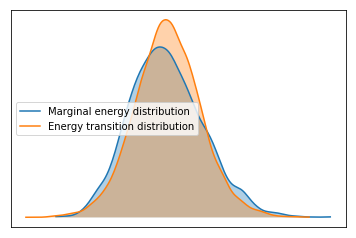

In [113]:
# Sample the model using ADVI as the initialization method for the NUTS sampler
# (the default setting will cause an error)
# with model:
#     trace = pm.sample(draws=2000,
#                       tune=5000,
#                       nuts_kwargs={'target_accept': 0.9999},
#                       init='advi+adapt_diag',
#                       njobs=1)

with model:
    trace = pm.sample(draws=2000,
                      tune=1000,
                      nuts_kwargs={'target_accept': 0.9999},
                      init='advi+adapt_diag',
                      njobs=4)

joblib.dump(trace, 'trace_age.pkl')
print(max(np.max(score) for score in pm.gelman_rubin(trace).values()))
pm.energyplot(trace)

Number of Divergent 0
Percentage of Divergent 0.00000


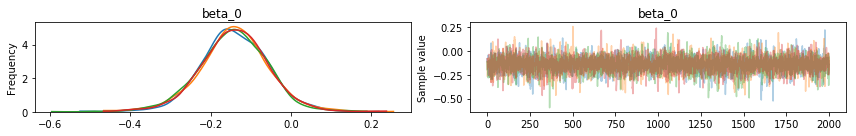

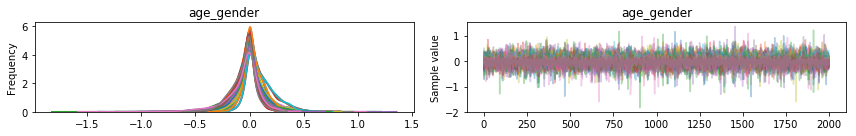

In [114]:
# Display the trace plot and density plot for each variable
model_vars = [beta_0, alpha_age_gender]

for var in model_vars:
    pm.traceplot(trace, varnames=[var])
    
# Display the total number and percentage of divergent transitions
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace)
print('Percentage of Divergent %.5f' % divperc)

100%|██████████| 1000/1000 [00:00<00:00, 1003.04it/s]


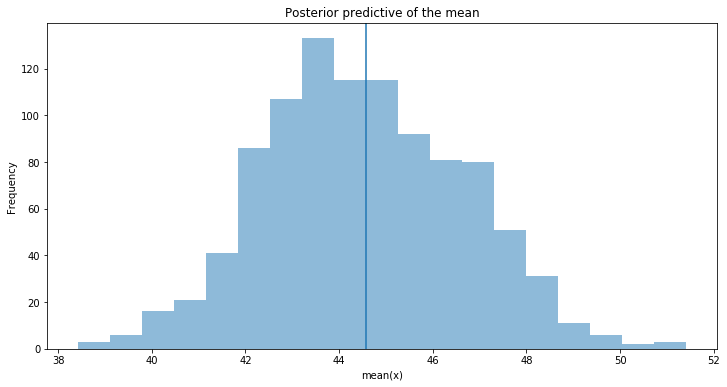

In [115]:
# Perform a posterior predictive check to ensure that the sample distribution overlaps with the dataset mean
ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([k.mean() for k in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index6_unique["More Important Quality|Self-reliance"].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency'); 

In [116]:
# Load 2016 Census Bureau state/gender/age data
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2016/state/asrh/sc-est2016-agesex-civ.csv
census = pd.read_csv('/Users/deborahchung/repos/MSR2/demographics/sc-est2016-agesex-civ.csv')

census = census.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE',
                      'ESTBASE2010_CIV', 'POPEST2010_CIV', 'POPEST2011_CIV', 'POPEST2012_CIV',
                      'POPEST2013_CIV', 'POPEST2014_CIV', 'POPEST2015_CIV'], axis=1)
#Remove national level and child population counts

census = census.loc[census['NAME'] == 'United States']
census = census.loc[census['AGE'] >= 18]
census = census.loc[census['AGE'] != 999]
census = census.loc[census['SEX'] != 0]

#Rename gender categories (male = 1, female = 2) to match the survey data

census.loc[census['SEX'] == 2, 'SEX'] = 0

In [117]:
census.head()

,NAME,SEX,AGE,POPEST2016_CIV
105,United States,1,18,2143115
106,United States,1,19,2124265
107,United States,1,20,2142923
108,United States,1,21,2191286
109,United States,1,22,2237338


In [118]:
# Sum population counts based on the survey data age ranges
age_tuples = [(18, 24), (25, 34), (35, 44), (45, 54), (55, 85)]
age_ranges = ['18 - 24', '25 - 34', '35 - 44', '45 - 54', '> 54']
counts = list()

for marginal in product(census['NAME'].unique(), census['SEX'].unique(), age_tuples):
    counts.append((marginal[0], marginal[1], marginal[2],
                   census.loc[(census['NAME'] == marginal[0]) &
                              (census['SEX'] == marginal[1]) &
                              (census['AGE'] >= marginal[2][0]) &
                              (census['AGE'] <= marginal[2][1])]['POPEST2016_CIV'].sum()))

#Rename column names and age ranges to match the survey data
    
state_age_gender = pd.DataFrame.from_records(counts, columns=['Area', 'Gender', 'Age', 'n'])

for age_range in zip(age_tuples, age_ranges):
    state_age_gender.loc[state_age_gender['Age'] == age_range[0], 'Age'] = age_range[1]
    
#Merge the state-level data with the Census data to perform poststratification

# ps_df = pd.merge(state_df, state_age_gender, on='Area')
ps_df = state_age_gender.copy() 

In [119]:
census['NAME'].unique()

array(['United States'], dtype=object)

In [120]:

def concat(col1, col2):
    pair = (col1, col2)
        
    return str(pair)

age_gender_list = [str(marginal) for marginal in product(ps_df['Age'].unique(), ps_df['Gender'].unique())]

ps_df['Age_Gender'] = ps_df[['Age', 'Gender']].apply(lambda row: concat(row[0], row[1]), axis=1)
age_gender_enc = LabelEncoder()
age_gender_enc.fit(age_gender_list)
ps_df['Age_Gender'] = age_gender_enc.transform(ps_df['Age_Gender'])

#Encode the age ranges into integers

age_enc = LabelEncoder()
ps_df['Age Encoded'] = age_enc.fit_transform(ps_df['Age'])

In [121]:
ps_df

,Area,Gender,Age,n,Age_Gender,Age Encoded
0,United States,1,18 - 24,15461395,1,0
1,United States,1,25 - 34,22203979,3,1
2,United States,1,35 - 44,19955082,5,2
3,United States,1,45 - 54,21055295,7,3
4,United States,1,> 54,41788541,9,4
5,United States,0,18 - 24,14951964,0,0
6,United States,0,25 - 34,21997310,2,1
7,United States,0,35 - 44,20283832,4,2
8,United States,0,45 - 54,21671837,6,3
9,United States,0,> 54,48914630,8,4


In [122]:
# Set the previously defined Theano variables to the poststratification values
age_gender.set_value(ps_df['Age_Gender'].values)
n.set_value(ps_df['n'].values)

100%|██████████| 1000/1000 [00:00<00:00, 1000.36it/s]


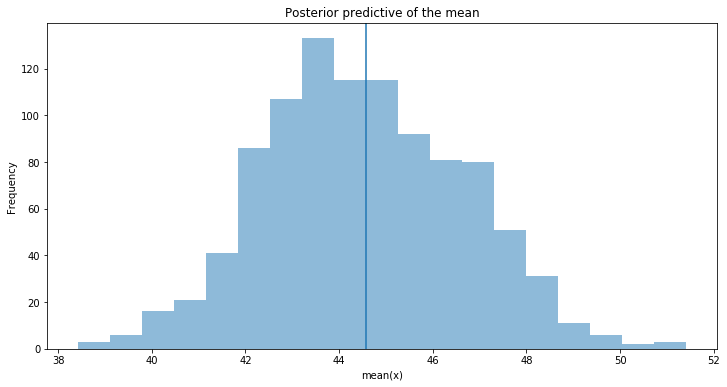

In [123]:
# Draw a new sample from the posterior predictive distribution
ps_ppc = pm.sample_ppc(trace, samples=1000, model=model)

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([k.mean() for k in ppc['obs']], bins=19, alpha=0.5)
ax.axvline(index6_unique["More Important Quality|Self-reliance"].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency'); 


In [124]:
#Merge the state-level data with the posterior distribution sample

PP_COLS = ['DK_{}'.format(i) for i in range(ps_ppc['obs'].shape[0])]
ppc_df = pd.merge(ps_df, pd.DataFrame(ps_ppc['obs'].T, columns=PP_COLS),
                  left_index=True, right_index=True)

#Calcuate the average probability of each demographic answering "Don't know" over all samples

cell_prob = ppc_df.groupby(['Area',
                            'Gender',
                            'Age']).apply(lambda df: df[PP_COLS].mean(axis=1)/df['n'])

#Calculate a weighted average to obtain the probability of respodents in each state answering "Don't know"

# area_prob = ppc_df.groupby(['Area']).apply(lambda df: df[PP_COLS].mean(axis=0)/df['n'].sum()).mean(axis=1)

In [125]:
cell_prob

Area           Gender  Age       
United States  0       18 - 24  5    0.466927
                       25 - 34  6    0.472911
                       35 - 44  7    0.467416
                       45 - 54  8    0.463080
                       > 54     9    0.456703
               1       18 - 24  0    0.470732
                       25 - 34  1    0.488165
                       35 - 44  2    0.475368
                       45 - 54  3    0.451980
                       > 54     4    0.457152
dtype: float64

In [127]:
cell_prob_df = pd.DataFrame(data=cell_prob)

In [128]:
cell_prob_df.to_csv('age_gender_selfreliance.csv')

In [129]:
cell_prob_df

0
Area          Gender Age                
United States 0      18 - 24 5  0.466927
                     25 - 34 6  0.472911
                     35 - 44 7  0.467416
                     45 - 54 8  0.463080
                     > 54    9  0.456703
              1      18 - 24 0  0.470732
                     25 - 34 1  0.488165
                     35 - 44 2  0.475368
                     45 - 54 3  0.451980
                     > 54    4  0.457152